In [201]:
# import libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import glob
from copy import deepcopy

## Read input data

In [2]:
scales = ['0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95', '1']
n_scales = len(scales)
n_faces = 34
n_words = 40
n_houses = 9


# load all images in `./faces/[scale]/polar`
faces = np.zeros([n_faces*n_scales, 32*32])
for i in range(n_scales):
    scale_dir = './faces/' + scales[i]
    face_files = glob.glob(scale_dir + '/polar/*.png')
    for ii in range(n_faces):
        face_ii = plt.imread(face_files[ii], format="png")
        faces[i*n_faces+ii] = np.average(face_ii, axis=2).reshape((1, 32*32))
face_labels = np.zeros(
    [n_faces*n_scales, n_faces+n_words+n_houses+n_words+1]
)    # Labels to be used as y. Column 0-33:faces, 34-73: words, 74-82:houses, 83-122:languages nodes, 123:word flag
face_labels[:, 0:n_faces] = np.tile(
    np.identity(n_faces), (n_scales, 1)
)
faces = np.hstack((faces, face_labels))

# load all images in `./words/[scale]/polar`
words = np.zeros([n_words*n_scales, 32*32])
for i in range(n_scales):
    scale_dir = './words/' + scales[i]
    word_files = glob.glob(scale_dir + '/polar/*.png')
    for ii in range(n_words):
        word_ii = plt.imread(word_files[ii], format="png")
        words[i*n_words+ii] = np.average(word_ii, axis=2).reshape((1, 32*32))
word_labels = np.zeros(
    [n_words*n_scales, n_faces+n_words+n_houses+n_words+1]
)
word_labels[:, n_faces:(n_faces+n_words)] = np.tile(
    np.identity(n_words), (n_scales, 1)
)
word_labels[:, (n_faces+n_words+n_houses):(n_faces+n_words+n_houses+n_words)] = np.tile(
    np.identity(n_words), (n_scales, 1)
)
word_labels[:, 123] = np.repeat(1, n_words*n_scales)
words = np.hstack((words, word_labels))

# load all images in `./houses/[scale]/polar`
houses = np.zeros([n_houses*n_scales, 32*32])
for i in range(n_scales):
    scale_dir = './houses/' + scales[i]
    house_files = glob.glob(scale_dir + '/polar/*.png')
    for ii in range(n_houses):
        house_ii = plt.imread(house_files[ii], format="png")
        houses[i*n_houses+ii] = np.average(house_ii, axis=2).reshape((1, 32*32))
house_labels = np.zeros(
    [n_houses*n_scales, n_faces+n_words+n_houses+n_words+1]
)
house_labels[:, (n_faces+n_words):(n_faces+n_words+n_houses)] = np.tile(
    np.identity(n_houses), (n_scales, 1)
)
houses = np.hstack((houses, house_labels))


all_data = np.vstack((faces, words, houses))
# input_date: Every row is a stimulus; column 0-1023: grayscale value of a stimulus, 
# 1024-1057:identity for faces, 1058-1097:identity for words, 1098-1106: identity 
# for houses, 1107-1146: language unites, 1147: word flags

In [3]:
all_data.shape

(747, 1148)

In [4]:
data_train = all_data

x_notw = data_train[data_train[:, -1] == 0][:, 0:1024]
x_w = data_train[data_train[:, -1] == 1][:, 0:1024]
x_notw = np.transpose(x_notw)    # 1024x387
x_w = np.transpose(x_w)    # 1024x360

y_notw = data_train[data_train[:, 1147] == 0][:, 1024:1107]
y_w = data_train[data_train[:, 1147] == 1][:, 1024:1147]
y_notw = np.transpose(y_notw)    # 83x387
y_w = np.transpose(y_w)    # 123x360

In [5]:
x_notw.shape

(1024, 387)

In [6]:
x_w.shape

(1024, 360)

In [7]:
y_notw.shape

(83, 387)

In [8]:
y_w.shape

(123, 360)

## The model

In [460]:
##########################################################
#####     Our neural netword for faces and words     #####
##########################################################


# subfunctions and their derivatives we are going to use 
def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def Relu(Z):
    return np.maximum(0, Z)

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    return (s * (1-s))

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

# not using the mean squared error function as the loss function
# use the cross-entropy function as the loss function `nloss`
def nloss(y_notw, y_w, Yh_notw, Yh_w):
    n_notw = y_notw.shape[1]    # 387
    n_w = y_w.shape[1]    # 360
    
    loss_notw = np.sum(
        np.diagonal(
            (1./n_notw) * 
            (
                -np.matmul(y_notw, np.log(Yh_notw).T) - 
                np.matmul(1-y_notw, np.log(1-Yh_notw).T)
            )
        )
    )
    loss_w = np.sum(
        np.diagonal(
            (1./n_w) * 
            (
                -np.matmul(y_w, np.log(Yh_w).T) - 
                np.matmul(1-y_w, np.log(1-Yh_w).T)
            )
        )
    )
    loss = loss_notw + loss_w
    return (loss, loss_notw, loss_w)


# We create a Python class that setups, initializes and train the network
class fwnet():
    def __init__(self, data, n_iter = 1000, lr = 0.003):    # data should be 747x1148
        self.dims = [1024, 64, 83]
        self.lang_unit_n = 40
        self.n_iter = n_iter
        
        self.x_notw = data[data[:, -1] == 0][:, 0:self.dims[0]]
        self.x_w = data[data[:, -1] == 1][:, 0:self.dims[0]]
        self.x_notw = np.transpose(self.x_notw)    # 1024x387
        self.x_w = np.transpose(self.x_w)    # 1024x360

        self.y_notw = data[data[:, -1] == 0][:, self.dims[0]:1107]
        self.y_w = data[data[:, -1] == 1][:, self.dims[0]:1147]
        self.y_notw = np.transpose(self.y_notw)    # 83x387
        self.y_w = np.transpose(self.y_w)    # 123x360
        
        self.n_notw = self.y_notw.shape[1]
        self.n_w = self.y_w.shape[1]
        
        self.Yh_notw = np.zeros((self.dims[2], self.y_notw.shape[1]))    # 83x387
        self.Yh_w = np.zeros(((self.dims[2]+self.lang_unit_n), self.y_w.shape[1]))    # 123x360
        
        self.param = {}    # dictionary that stores weights and betas
        self.ch = {}    # cache dictionary that stores intermediate calculation results
        
        self.loss = np.tile(np.zeros((self.n_iter, 1)), 3)
        self.lr = lr
        
        norm_pd = norm.pdf(np.linspace(0, 31, 32), loc=0, scale=3)
        self.bias = np.zeros((32, 32))
        for i in range(self.bias.shape[0]):
            for j in range(self.bias.shape[1]):
                self.bias[i, j] = norm_pd[abs(i-j)]
        self.bias = np.tile(self.bias, (2, 32))
        return
    
    
    # initialize with random values the parameters of our network
    def nInit(self):
        # LW1 shape 64x1024
        self.param['LW1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0])
        
        # Lb1 shape 64x1
        self.param['Lb1'] = np.random.normal(size=(self.dims[1], 1))
        
        # RW1 shape 64x1024
        self.param['RW1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0])
        
        # Rb1 shape 64x1
        self.param['Rb1'] = np.random.normal(size=(self.dims[1], 1))
        
        
        # W2_w and b2_w include identity and language units for both word and notword stimuli
        # bottom 40 columns are weights connecting language units, used for words
        # W2_w[83:123, 64:128] and b2_w[83:123] should be 0
        ## W2_w shape 123x128
        self.param['W2_w'] = np.random.randn(
            (self.dims[2]+self.lang_unit_n), 2*self.dims[1]
        ) / np.sqrt(2*self.dims[1])
        ### set weights connecting right fusiform and language units = 0
        self.param['W2_w'][83:123, 64:128] = 0
        ## b2_w shape 123x1
        self.param['b2_w'] = np.random.normal(size=((self.dims[2]+self.lang_unit_n), 1))
        ### set betas of connections between right fusiform and language units = 0
        self.param['b2_w'][83:123, :] = 0
        # top 83 columns only connecting to identity units, used for all stimuli
        ## W2 shape 83x128
        self.param['W2_notw'] = self.param['W2_w'][0:83, :]
        ## b2 shape 83x1
        self.param['b2_notw'] = self.param['b2_w'][0:83, :]
                
        return
    
    
    def forward(self):
        #######################################
        #####     for notword stimuli     #####
        #######################################
        # input to intermediate layer
        ## left fusiform
        LZ1_notw = np.matmul(self.param['LW1'], self.x_notw) + self.param['Lb1']    # 64x387
        LA1_notw = Relu(LZ1_notw)    # 64x387
        self.ch['LZ1_notw'] = LZ1_notw
        self.ch['LA1_notw'] = LA1_notw
        ## right fusiform
        RZ1_notw = np.matmul(self.param['RW1'], self.x_notw) + self.param['Rb1']    # 64x387
        RA1_notw = Relu(RZ1_notw)    # 64x387
        self.ch['RZ1_notw'] = RZ1_notw
        self.ch['RA1_notw'] = RA1_notw
        
        # intermediate layer to output
#         self.param['W2_notw'] = self.param['W2_w'][0:83, :]
#         self.param['b2_notw'] = self.param['b2_w'][0:83, :]
        ## combine the two fusiform intermediate layers
        Z1_notw = np.vstack((self.ch['LZ1_notw'], self.ch['RZ1_notw']))    # 128x387
        A1_notw = np.vstack((self.ch['LA1_notw'], self.ch['RA1_notw']))    # 128x387
        self.ch['Z1_notw'] = Z1_notw
        self.ch['A1_notw'] = A1_notw
        ## calculate Z2 and A2 (identity output)
        Z2_notw = np.matmul(self.param['W2_notw'], A1_notw) + self.param['b2_notw']    # 83x387
        A2_notw = Sigmoid(Z2_notw)    # 83x387
        self.ch['Z2_notw'] = Z2_notw
        self.ch['A2_notw'] = A2_notw
        
        self.Yh_notw = A2_notw    # 83x387
        
        
        ####################################
        #####     for word stimuli     #####
        ####################################
        # input to intermediate layer
        ## left fusiform
        LZ1_w = np.matmul(self.param['LW1'], self.x_w) + self.param['Lb1']    # 64x360
        LA1_w = Relu(LZ1_w)    # 64x360
        self.ch['LZ1_w'] = LZ1_w
        self.ch['LA1_w'] = LA1_w
        ## right fusiform
        RZ1_w = np.matmul(self.param['RW1'], self.x_w) + self.param['Rb1']    # 64x360
        RA1_w = Relu(RZ1_w)    # 64x360
        self.ch['RZ1_w'] = RZ1_w
        self.ch['RA1_w'] = RA1_w
        
        # intermediate layer to output
        ## combine the two fusiform intermediate layers
        Z1_w = np.vstack((self.ch['LZ1_w'], self.ch['RZ1_w']))    # 128x360
        A1_w = np.vstack((self.ch['LA1_w'], self.ch['RA1_w']))    # 128x360
        self.ch['Z1_w'] = Z1_w
        self.ch['A1_w'] = A1_w
        ## calculate Z2 and A2 (identity output)
        Z2_w = np.matmul(self.param['W2_w'], A1_w) + self.param['b2_w']    # 123x360
        A2_w = Sigmoid(Z2_w)    # 123x360
        self.ch['Z2_w'] = Z2_w
        self.ch['A2_w'] = A2_w
        
        self.Yh_w = A2_w    # 123x360
        
        
        loss = nloss(self.y_notw, self.y_w, self.Yh_notw, self.Yh_w)
        
        return self.Yh_notw, self.Yh_w, loss
    
    
    
    # backpropagation
    def backward(self):
        # calculate the gradients
        
        #######################################
        #####     for notword stimuli     #####
        #######################################
        dL_Yh_notw = -(
            np.divide(self.y_notw, self.Yh_notw) - 
            np.divide(1 - self.y_notw, 1 - self.Yh_notw)
        )    # 83x387
        
        dL_Z2_notw = dL_Yh_notw * dSigmoid(self.ch['Z2_notw'])    # 83x387
        dL_A1_notw = np.matmul(self.param['W2_notw'].T, dL_Z2_notw)    # 128x387
        dL_W2_notw = 1./self.ch['A1_notw'].shape[1] * np.matmul(dL_Z2_notw, self.ch['A1_notw'].T)    # 83x128
        dL_b2_notw = 1./self.ch['A1_notw'].shape[1] * np.matmul(dL_Z2_notw, np.ones([dL_Z2_notw.shape[1], 1]))    # 83x1
        
        
        # divide dLoss_A1 and dLoss_W2 into dLoss_LA1/dLoss_RA1 and dLoss_LW1/dLoss_RW1
        dL_LA1_notw = dL_A1_notw[0:self.dims[1], :]    # 64x387
        dL_LW2_notw = dL_W2_notw[:, 0:self.dims[1]]    # 83x64
        dL_RA1_notw = dL_A1_notw[self.dims[1]:, :]    # 64x387
        dL_RW2_notw = dL_W2_notw[:, self.dims[1]:]    # 83x64
        
        
        dL_LZ1_notw = dL_LA1_notw * dRelu(self.ch['LZ1_notw'])    # 64x387
        dL_LA0_notw = np.matmul(self.param['LW1'].T, dL_LZ1_notw)    # 1024x387
        dL_LW1_notw = 1./self.x_notw.shape[1] * np.matmul(dL_LZ1_notw, self.x_notw.T)    # 64x1024
        dL_Lb1_notw = 1./self.x_notw.shape[1] * np.matmul(dL_LZ1_notw, np.ones([dL_LZ1_notw.shape[1], 1]))    # 64x1
        
                
        dL_RZ1_notw = dL_RA1_notw * dRelu(self.ch['RZ1_notw'])    # 64x387
        dL_RA0_notw = np.matmul(self.param['RW1'].T, dL_RZ1_notw)    # 1024x387
        dL_RW1_notw = 1./self.x_notw.shape[1] * np.matmul(dL_RZ1_notw, self.x_notw.T)    # 64x1024
        dL_Rb1_notw = 1./self.x_notw.shape[1] * np.matmul(dL_RZ1_notw, np.ones([dL_RZ1_notw.shape[1], 1]))    #64x1
        
        
        ####################################
        #####     for word stimuli     #####
        ####################################
        dL_Yh_w = -(
            np.divide(self.y_w, self.Yh_w ) - 
            np.divide(1 - self.y_w, 1 - self.Yh_w)
        )    # 123x360
        
        dL_Z2_w = dL_Yh_w * dSigmoid(self.ch['Z2_w'])    # 123x360
        dL_A1_w = np.matmul(self.param['W2_w'].T, dL_Z2_w)    # 128x360
        dL_W2_w = 1./self.ch['A1_w'].shape[1] * np.matmul(dL_Z2_w, self.ch['A1_w'].T)    # 123x128
        dL_b2_w = 1./self.ch['A1_w'].shape[1] * np.matmul(dL_Z2_w, np.ones([dL_Z2_w.shape[1], 1]))    #123x1
        
        
        
        # divide dLoss_A1 and dLoss_W2 into dLoss_LA1/dLoss_RA1 and dLoss_LW1/dLoss_RW1
        dL_LA1_w = dL_A1_w[0:self.dims[1], :]    # 64x360
        dL_LW2_w = dL_W2_w[:, 0:self.dims[1]]    # 123x64
        dL_RA1_w = dL_A1_w[self.dims[1]:, :]    # 64x360
        dL_RW2_w = dL_W2_w[:, self.dims[1]:]    # 123x64
        
        
        dL_LZ1_w = dL_LA1_w * dRelu(self.ch['LZ1_w'])    # 64x360
        dL_LA0_w = np.matmul(self.param['LW1'].T, dL_LZ1_w)    # 1024x360
        dL_LW1_w = 1./self.x_w.shape[1] * np.matmul(dL_LZ1_w, self.x_w.T)    # 64x1024
        dL_Lb1_w = 1./self.x_w.shape[1] * np.matmul(dL_LZ1_w, np.ones([dL_LZ1_w.shape[1], 1]))    # 64x1
        
        
        dL_RZ1_w = dL_RA1_w * dRelu(self.ch['RZ1_w'])    # 64x360
        dL_RA0_w = np.matmul(self.param['RW1'].T, dL_RZ1_w)    # 1024x360
        dL_RW1_w = 1./self.x_w.shape[1] * np.matmul(dL_RZ1_w, self.x_w.T)    # 64x1024
        dL_Rb1_w = 1./self.x_w.shape[1] * np.matmul(dL_RZ1_w, np.ones([dL_RZ1_w.shape[1], 1]))    #64x1
        
        
        
        # do the backpropagation
        
        ## input - intermediate layers
        ### backpropagation in left fusiform
        self.param['LW1'] = self.param['LW1'] - self.lr * self.bias * (dL_LW1_notw + dL_LW1_w)
        self.param['Lb1'] = self.param['Lb1'] - self.lr * (dL_Lb1_notw + dL_Lb1_w)
        
        ### backpropagation in right fusiform
        self.param['RW1'] = self.param['RW1'] - self.lr * self.bias * (dL_RW1_notw + dL_RW1_w)
        self.param['Rb1'] = self.param['Rb1'] - self.lr * (dL_Rb1_notw + dL_Rb1_w)
        
        ## intermediate layers - output
        ### notword
        ### backpropagation for W2_notw and B2_notw
        self.param['W2_notw'] = self.param['W2_notw'] - self.lr * dL_W2_notw
        self.param['b2_notw'] = self.param['b2_notw'] - self.lr * dL_b2_notw
        self.param['W2_w'][0:83, :] = self.param['W2_notw']
        self.param['b2_w'][0:83, :] = self.param['b2_notw']
        
        ### word
        ### backpropagation for W2_w and B2_w
        self.param['W2_w'] = self.param['W2_w'] - self.lr * dL_W2_w
        self.param['W2_w'][83:123, 64:128] = 0
        self.param['b2_w'] = self.param['b2_w'] - self.lr * dL_b2_w
        self.param['b2_w'][83:123, :] = 0
        self.param['W2_notw'] = self.param['W2_w'][0:83, :]
        self.param['b2_notw'] = self.param['b2_w'][0:83, :]
        
        
        return
    
    def pred(self, data):    # data should be 747x1148
        x_notw = data[data[:, -1] == 0][:, 0:1024]
        x_w = data[data[:, -1] == 1][:, 0:1024]
        x_notw = np.transpose(x_notw)    # 1024x387
        x_w = np.transpose(x_w)    # 1024x360

        y_notw = data[data[:, 1147] == 0][:, 1024:1107]
        y_w = data[data[:, 1147] == 1][:, 1024:1147]
        y_notw = np.transpose(y_notw)    # 83x387
        y_w = np.transpose(y_w)    # 123x360
        
        results= {}
        
        #######################################
        #####     for notword stimuli     #####
        #######################################
        # input to intermediate layer
        ## left fusiform
        LZ1_notw = np.matmul(self.param['LW1'], x_notw) + self.param['Lb1']    # 64x387
        LA1_notw = Relu(LZ1_notw)    # 64x387
        
        ## right fusiform
        RZ1_notw = np.matmul(self.param['RW1'], x_notw) + self.param['Rb1']    # 64x387
        RA1_notw = Relu(RZ1_notw)    # 64x387
        
        
        # intermediate layer to output
        ## combine the two fusiform intermediate layers
        Z1_notw = np.vstack((LZ1_notw, RZ1_notw))    # 128x387
        A1_notw = np.vstack((LA1_notw, RA1_notw))    # 128x387
        
        ## calculate Z2 and A2 (identity output)
        Z2_notw = np.matmul(self.param['W2_notw'], A1_notw) + self.param['b2_notw']    # 83x387
        preds_notw = Sigmoid(Z2_notw)    # 83x387
        
        
        
        ####################################
        #####     for word stimuli     #####
        ####################################
        # input to intermediate layer
        ## left fusiform
        LZ1_w = np.matmul(self.param['LW1'], x_w) + self.param['Lb1']    # 64x360
        LA1_w = Relu(LZ1_w)    # 64x360
        
        ## right fusiform
        RZ1_w = np.matmul(self.param['RW1'], x_w) + self.param['Rb1']    # 64x360
        RA1_w = Relu(RZ1_w)    # 64x360
        
        
        # intermediate layer to output
        ## combine the two fusiform intermediate layers
        Z1_w = np.vstack((LZ1_w, RZ1_w))    # 128x360
        A1_w = np.vstack((LA1_w, RA1_w))    # 128x360
        
        ## calculate Z2 and A2 (identity output)
        Z2_w = np.matmul(self.param['W2_w'], A1_w) + self.param['b2_w']    # 123x360
        preds_w = Sigmoid(Z2_w)    # 123x360
        
        results['loss'] = nloss(y_notw, y_w, preds_notw, preds_w)
        
        preds_notw = np.transpose(preds_notw)
        preds_w = np.transpose(preds_w)
        labels_notw = (preds_notw == preds_notw.max(axis=1)[:,None]).astype(int)
        labels_w = np.hstack((
            (preds_w[:, 0:83] == preds_w[:, 0:83].max(axis=1)[:,None]).astype(int), 
            (preds_w[:, 83:] == preds_w[:, 83:].max(axis=1)[:,None]).astype(int)
        ))
        
        results['activations'] = (preds_notw, preds_w)
        results['labels'] = (labels_notw, labels_w)
        
        
        return results
    
    
    def learn(self):
#         np.random.seed(1)                         
        
        self.nInit()
        
        for i in range(self.n_iter):
            Yh_notw, Yh_w, loss = self.forward()
            self.backward()
            self.loss[i] = loss
#             if (i+1) % 1000 == 0:
#                 print(
#                     'Cost after iteration {0:d} (total, notw, w): {1:0.4f}, {2:0.4f}, {3:0.4f}'.format(
#                         i+1, loss[0], loss[1], loss[2]
#                     )
#                 )
#                 print(self.param['W1'])
        
        return

## RUN!!

In [194]:
nn = fwnet(data_train, n_iter = 20000, lr = 0.05)
nn.learn()

Cost after iteration 1000 (total, notw, w): 13.3928, 4.3561, 9.0367
Cost after iteration 2000 (total, notw, w): 11.1357, 3.8770, 7.2586
Cost after iteration 3000 (total, notw, w): 9.1194, 3.4917, 5.6277
Cost after iteration 4000 (total, notw, w): 7.5942, 3.1333, 4.4610
Cost after iteration 5000 (total, notw, w): 6.4082, 2.8411, 3.5671
Cost after iteration 6000 (total, notw, w): 5.3322, 2.4885, 2.8437
Cost after iteration 7000 (total, notw, w): 4.8283, 2.3782, 2.4501
Cost after iteration 8000 (total, notw, w): 4.0316, 2.1537, 1.8779
Cost after iteration 9000 (total, notw, w): 3.5023, 1.8949, 1.6075
Cost after iteration 10000 (total, notw, w): 3.1634, 1.7771, 1.3862
Cost after iteration 11000 (total, notw, w): 2.6950, 1.5955, 1.0995
Cost after iteration 12000 (total, notw, w): 2.5314, 1.5461, 0.9853
Cost after iteration 13000 (total, notw, w): 2.2965, 1.4174, 0.8792
Cost after iteration 14000 (total, notw, w): 2.0121, 1.2830, 0.7292
Cost after iteration 15000 (total, notw, w): 1.8920, 1.

In [410]:
preds = nn.pred(data_train)
activations = preds['activations']
activations_notw = activations[0]
activations_w = activations[1]
labels = preds['labels']
labels_notw = labels[0]
labels_w = labels[1]

In [411]:
# accuracy w
np.sum((np.sum(abs(labels_w - y_w.T), axis=1)==0).astype(int)) / 360

1.0

In [412]:
# accuracy notw
1 - (np.sum(abs(labels_notw - y_notw.T))/2) / 387

0.937984496124031

In [414]:
labels_faces = labels_notw[0:306, :]
labels_houses = labels_notw[306:, :]
y_faces = y_notw.T[0:306, :]
y_houses = y_notw.T[306:, :]

# accuracy faces
1 - (np.sum(abs(labels_faces - y_faces))/2) / 306

0.9215686274509804

In [415]:
# accuracy houses
1 - (np.sum(abs(labels_houses - y_houses))/2) / 81

1.0

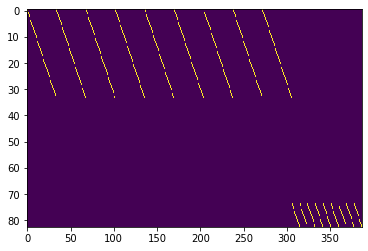

In [210]:
plt.imshow(y_notw, aspect='auto')

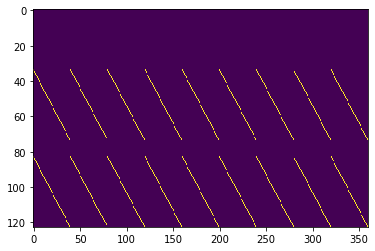

In [211]:
plt.imshow(y_w, aspect='auto')

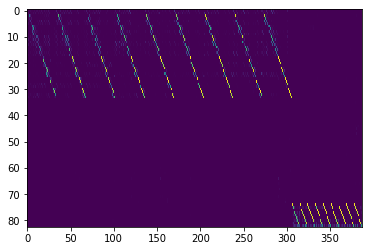

In [212]:
plt.imshow(activations_notw.T, aspect='auto')

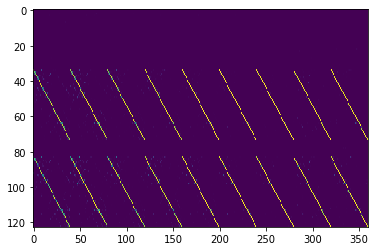

In [213]:
plt.imshow(activations_w.T, aspect='auto')

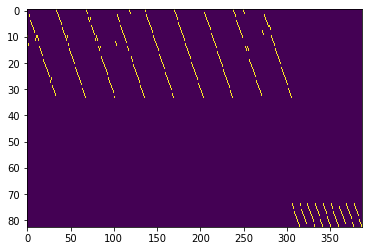

In [214]:
plt.imshow(labels_notw.T, aspect='auto')

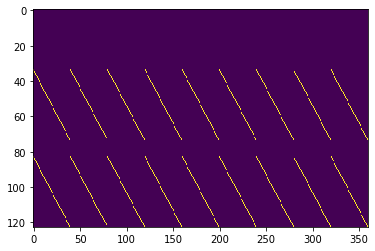

In [215]:
plt.imshow(labels_w.T, aspect='auto')

## Examination

### Performance as a function of number of training iterations

In [467]:
# use lr = 0.05
n_iters = np.linspace(1000, 20000, 11).astype(int)
nns = [fwnet(data_train, lr=0.05) for i in range(11)]
acc = {'words': np.zeros(11), 
       'faces': np.zeros(11), 
       'houses': np.zeros(11)}
for i in range(11):
    nns[i].n_iter = n_iters[i]
    nns[i].loss = np.tile(np.zeros((n_iters[i], 1)), 3)
    nns[i].learn()
    # calculate accuracy
    labels = nns[i].pred(data_train)['labels']
    labels_w = labels[1]
    labels_faces = labels[0][0:306, :]
    labels_houses = labels[0][306:, :]
    y_faces = y_notw.T[0:306, :]
    y_houses = y_notw.T[306:, :]
    # accuracy w
    acc['words'][i] = np.sum((np.sum(abs(labels_w - y_w.T), axis=1)==0).astype(int)) / 360
    # accuracy faces
    acc['faces'][i] = 1 - (np.sum(abs(labels_faces - y_faces))/2) / 306
    # accuracy houses
    acc['houses'][i] = 1 - (np.sum(abs(labels_houses - y_houses))/2) / 81

KeyboardInterrupt: 

In [ ]:
plt.plot(n_iters, acc['words'])
plt.plot(n_iters, acc['faces'])
plt.plot(n_iters, acc['houses'])
plt.legend(['words', 'faces', 'houses'])
plt.ylabel('Correct rate')
plt.xlabel('Iteration #')

### Lesions

In [468]:
lesion_ind = np.linspace(0, 29, 30).astype(int)

# left fusiform lesion
l_acc = {'words': np.zeros(30), 
         'faces': np.zeros(30), 
         'houses': np.zeros(30)}
for i in range(30):
    # copy weights from nn
    temp_LW1 = deepcopy(nn.param['LW1'])
    temp_Lb1 = deepcopy(nn.param['Lb1'])
    temp_RW1 = deepcopy(nn.param['RW1'])
    temp_Rb1 = deepcopy(nn.param['Rb1'])
    temp_W2_w = deepcopy(nn.param['W2_w'])
    temp_b2_w = deepcopy(nn.param['b2_w'])
    temp_W2_notw = deepcopy(nn.param['W2_notw'])
    temp_b2_notw = deepcopy(nn.param['b2_notw'])
    
    # lesion
    nn.param['LW1'][lesion_ind[i], :] = 0
    nn.param['LW1'][32+lesion_ind[i], :] = 0
    nn.param['W2_w'][:, lesion_ind[i]] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]] = 0
    nn.param['W2_notw'][:, lesion_ind[i]] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]] = 0
    nn.param['LW1'][lesion_ind[i]+1, :] = 0
    nn.param['LW1'][32+lesion_ind[i]+1, :] = 0
    nn.param['W2_w'][:, lesion_ind[i]+1] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]+1] = 0
    nn.param['W2_notw'][:, lesion_ind[i]+1] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]+1] = 0
    nn.param['LW1'][lesion_ind[i]+2, :] = 0
    nn.param['LW1'][32+lesion_ind[i]+2, :] = 0
    nn.param['W2_w'][:, lesion_ind[i]+2] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]+2] = 0
    nn.param['W2_notw'][:, lesion_ind[i]+2] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]+2] = 0
    
    # calculate accuracy
    labels = nn.pred(data_train)['labels']
    labels_w = labels[1]
    labels_faces = labels[0][0:306, :]
    labels_houses = labels[0][306:, :]
    y_faces = y_notw.T[0:306, :]
    y_houses = y_notw.T[306:, :]
    # accuracy w
    l_acc['words'][i] = np.sum((np.sum(abs(labels_w - y_w.T), axis=1)==0).astype(int)) / 360
    # accuracy faces
    l_acc['faces'][i] = 1 - (np.sum(abs(labels_faces - y_faces))/2) / 306
    # accuracy houses
    l_acc['houses'][i] = 1 - (np.sum(abs(labels_houses - y_houses))/2) / 81
    
    # restore weitghts
    nn.param['LW1'] = deepcopy(temp_LW1)
    nn.param['Lb1'] = deepcopy(temp_Lb1)
    nn.param['RW1'] = deepcopy(temp_RW1)
    nn.param['Rb1'] = deepcopy(temp_Rb1)
    nn.param['W2_w'] = deepcopy(temp_W2_w)
    nn.param['b2_w'] = deepcopy(temp_b2_w)
    nn.param['W2_notw'] = deepcopy(temp_W2_notw)
    nn.param['b2_notw'] = deepcopy(temp_b2_notw)

([], <a list of 0 Text xticklabel objects>)

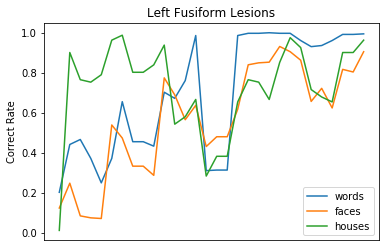

In [474]:
plt.plot(l_acc['words'])
plt.plot(l_acc['faces'])
plt.plot(l_acc['houses'])
plt.legend(['words', 'faces', 'houses'])
plt.title('Left Fusiform Lesions')
plt.ylabel('Correct Rate')
plt.xticks([])

In [470]:
lesion_ind = np.linspace(0, 29, 30).astype(int)

# right fusiform lesion
r_acc = {'words': np.zeros(30), 
         'faces': np.zeros(30), 
         'houses': np.zeros(30)}
for i in range(30):
    # copy weights from nn
    temp_LW1 = deepcopy(nn.param['LW1'])
    temp_Lb1 = deepcopy(nn.param['Lb1'])
    temp_RW1 = deepcopy(nn.param['RW1'])
    temp_Rb1 = deepcopy(nn.param['Rb1'])
    temp_W2_w = deepcopy(nn.param['W2_w'])
    temp_b2_w = deepcopy(nn.param['b2_w'])
    temp_W2_notw = deepcopy(nn.param['W2_notw'])
    temp_b2_notw = deepcopy(nn.param['b2_notw'])
    
    # lesion
    nn.param['RW1'][lesion_ind[i], :] = 0
    nn.param['RW1'][32+lesion_ind[i], :] = 0
    nn.param['W2_w'][:, lesion_ind[i]+64] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]+64] = 0
    nn.param['W2_notw'][:, lesion_ind[i]+64] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]+64] = 0
    nn.param['RW1'][lesion_ind[i]+1, :] = 0
    nn.param['RW1'][32+lesion_ind[i]+1, :] = 0
    nn.param['W2_w'][:, lesion_ind[i]+64+1] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]+64+1] = 0
    nn.param['W2_notw'][:, lesion_ind[i]+64+1] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]+64+1] = 0
    nn.param['RW1'][lesion_ind[i]+2, :] = 0
    nn.param['RW1'][32+lesion_ind[i]+2, :] = 0
    nn.param['W2_w'][:, lesion_ind[i]+64+2] = 0
    nn.param['W2_w'][:, 32+lesion_ind[i]+64+2] = 0
    nn.param['W2_notw'][:, lesion_ind[i]+64+2] = 0
    nn.param['W2_notw'][:, 32+lesion_ind[i]+64+2] = 0
    
    # calculate accuracy
    labels = nn.pred(data_train)['labels']
    labels_w = labels[1]
    labels_faces = labels[0][0:306, :]
    labels_houses = labels[0][306:, :]
    y_faces = y_notw.T[0:306, :]
    y_houses = y_notw.T[306:, :]
    # accuracy w
    r_acc['words'][i] = np.sum((np.sum(abs(labels_w - y_w.T), axis=1)==0).astype(int)) / 360
    # accuracy faces
    r_acc['faces'][i] = 1 - (np.sum(abs(labels_faces - y_faces))/2) / 306
    # accuracy houses
    r_acc['houses'][i] = 1 - (np.sum(abs(labels_houses - y_houses))/2) / 81
    
    # restore weitghts
    nn.param['LW1'] = deepcopy(temp_LW1)
    nn.param['Lb1'] = deepcopy(temp_Lb1)
    nn.param['RW1'] = deepcopy(temp_RW1)
    nn.param['Rb1'] = deepcopy(temp_Rb1)
    nn.param['W2_w'] = deepcopy(temp_W2_w)
    nn.param['b2_w'] = deepcopy(temp_b2_w)
    nn.param['W2_notw'] = deepcopy(temp_W2_notw)
    nn.param['b2_notw'] = deepcopy(temp_b2_notw)

([], <a list of 0 Text xticklabel objects>)

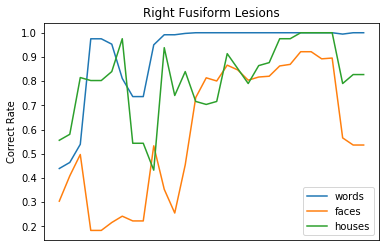

In [475]:
plt.plot(r_acc['words'])
plt.plot(r_acc['faces'])
plt.plot(r_acc['houses'])
plt.legend(['words', 'faces', 'houses'])
plt.title('Right Fusiform Lesions')
plt.ylabel('Correct Rate')
plt.xticks([])

### Indirect evidence for learned category specificity of intermediate units as a function of their eccentricity

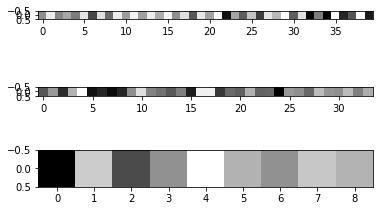

In [88]:
plt.subplot(3, 1, 1)
plt.imshow(nn.param['W2_notw'][0:40, 68].reshape([1,40]), cmap='Greys')
plt.subplot(3, 1, 2)
plt.imshow(nn.param['W2_notw'][40:74, 68].reshape([1,34]), cmap='Greys')
plt.subplot(3, 1, 3)
plt.imshow(nn.param['W2_notw'][74:, 68].reshape([1,9]), cmap='Greys')

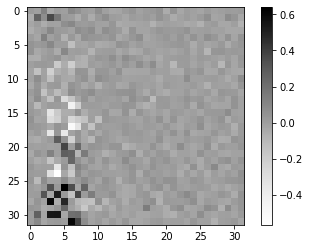

In [145]:
plt.imshow(nn.param['RW1'][5].reshape([32,32]), cmap='Greys')
plt.colorbar()

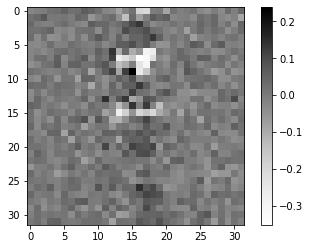

In [55]:
plt.imshow(nn.param['RW1'][16].reshape([32,32]), cmap='Greys')
plt.colorbar()

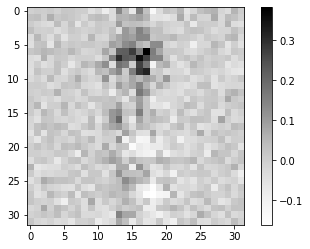

In [56]:
plt.imshow(nn.param['RW1'][17].reshape([32,32]), cmap='Greys')
plt.colorbar()